=== Resultados ===
TAPER_ALPHA: 0.02 | ENERGY_TARGET: 0.999
Dimensión base (k): 71
Band-pass métrico: True | Proyección (denoise): True | Zero-pad x2
Masa real: 6.000
Masa estimada (subrogado): 6.000
Error en estimación: 0.0000 M_sun
Mejor match (PyCBC): 0.9518
Tiempo barrido subrogado (todas las m): 7.2431 s
Tiempo surrogate(m) puro: 0.005015 s | comparar: 0.115604 s
Tiempo exacto (generación de onda): 0.3213 s


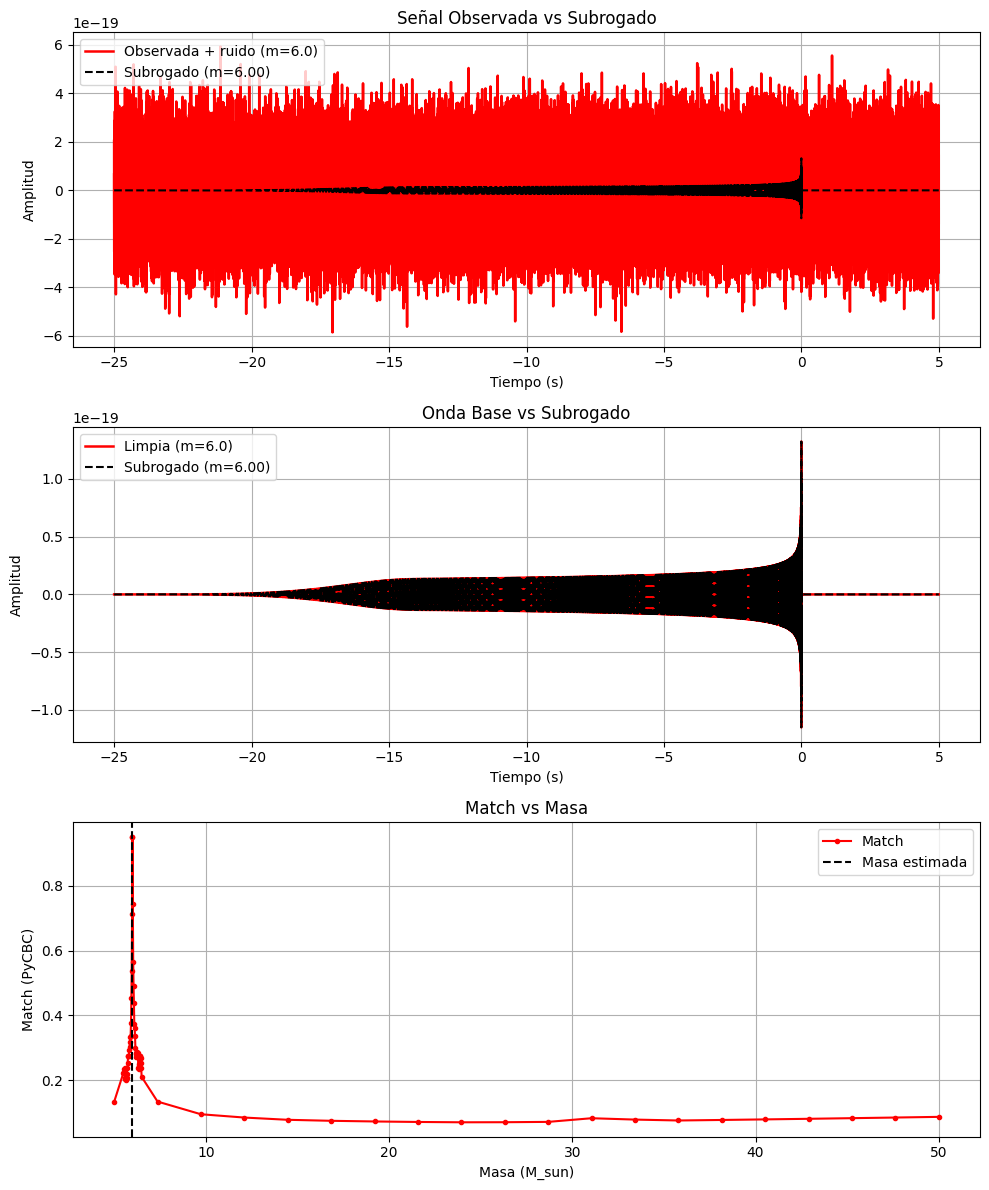

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Compatibilidad tukey (SciPy nuevo/viejo) ---
try:
    from scipy.signal.windows import tukey
except ImportError:
    from scipy.signal import get_window
    def tukey(M, alpha=0.1):
        return get_window(("tukey", alpha), M)

from scipy.signal import butter, filtfilt
from scipy.interpolate import PchipInterpolator

from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración
# ================================
np.random.seed(42)

delta_t = 1.0 / 4096.0
f_low = 20.0
f_high = 512.0       
apx = "SEOBNRv4_ROM"

# Ventana temporal 
T_BEFORE = 25.0
T_AFTER  = 5.0

# Taper más suave
TAPER_ALPHA = 0.02

# Varianza explicada de la base reducida
ENERGY_TARGET = 0.999

# Refinar malla alrededor de 6
COARSE_POINTS = 20
FINE_MIN, FINE_MAX, FINE_STEP = 5.5, 6.5, 0.02

# Mejoras activables
USE_BANDPASS      = True   # aplica band-pass SOLO para la métrica
USE_PROJECTION    = True   # proyecta observada en la base (denoise) para la métrica
ZERO_PAD_FACTOR   = 2      # 1 = sin zero-padding; 2 = duplica longitud para métrica

# ================================
# Utilidades
# ================================
def safe_time_slice(h, t_before=T_BEFORE, t_after=T_AFTER):
    """Centra en el pico de |h| y recorta ventana alrededor."""
    t_peak = h.sample_times[np.argmax(np.abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

def taper_arr(arr, alpha=TAPER_ALPHA):
    """Ventaneo Tukey leve para evitar bordes."""
    if alpha and alpha > 0:
        w = tukey(len(arr), alpha=alpha)
        return arr * w
    return arr

def preprocess_raw(h_ts, N):
    """
    Preprocesado 'crudo':
    - pad/trunc a N
    - taper leve
    - SIN blanqueo, SIN normalización (preserva escala/fase)
    """
    arr = h_ts.numpy()
    out = np.zeros(N, dtype=float)
    L = min(len(arr), N)
    out[:L] = arr[:L]
    out = taper_arr(out, alpha=TAPER_ALPHA)
    return out

def choose_k_by_energy(S, energy=ENERGY_TARGET):
    cum = np.cumsum(S**2) / np.sum(S**2)
    return int(np.searchsorted(cum, energy) + 1)

def bandpass(arr, fs, f1=f_low, f2=f_high, order=4):
    """Band-pass Butterworth para la MÉTRICA (no para plots/entrenamiento)."""
    nyq = 0.5 * fs
    b, a = butter(order, [f1/nyq, f2/nyq], btype='band')
    return filtfilt(b, a, arr)

def pad_to_length(x, M):
    out = np.zeros(M, dtype=float)
    L = min(len(x), M)
    out[:L] = x[:L]
    return out

def project_onto_basis(x, B):
    """
    Proyección ortogonal en el subespacio de la base reducida.
    Si B = U (SVD), sus columnas son ortonormales: P ≈ B B^T.
    """
    return B @ (B.T @ x)

# ================================
# Señal objetivo (m=6) y observada con ruido fuerte
# ================================
m_real = 6.0
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Ruido (SNR ~ 1)
sigma_noise = np.max(np.abs(hp_clean_np))
noise = np.random.normal(0.0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise  

# ================================
# Conjunto de masas
# ================================
mass_coarse = np.linspace(5.0, 50.0, COARSE_POINTS)
mass_fine   = np.arange(FINE_MIN, FINE_MAX + 1e-9, FINE_STEP)
mass_range  = np.unique(np.concatenate([mass_coarse, mass_fine, [6.0]]))

# ================================
# Matriz W
# ================================
W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h)
    h_arr = preprocess_raw(h, N)
    W_list.append(h_arr)
W = np.array(W_list).T  # [N x n_mass]

# ================================
# Base reducida (SVD)
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = choose_k_by_energy(S, energy=ENERGY_TARGET)
basis = U[:, :k]                 # [N x k]
coeffs = basis.T @ W             # [k x n_mass]

# ================================
# Interpolación de coeficientes vs masa
# ================================
interp_list = []
for i in range(k):
    pchip = PchipInterpolator(mass_range, coeffs[i, :], extrapolate=True)
    interp_list.append(pchip)

def surrogate_raw(m):
    """Predice h_cruda(m) (mismo recorte/taper, sin blanqueo/normalización)."""
    coeff_pred = np.array([p(m) for p in interp_list])   # [k]
    return basis @ coeff_pred                            # [N]

# ================================
# Preparar series para la métrica
# ================================
fs = 1.0 / delta_t

# Observada para la métrica:
obs_for_metric = hp_obs.copy()
if USE_PROJECTION:
    obs_for_metric = project_onto_basis(obs_for_metric, basis)
if USE_BANDPASS:
    obs_for_metric = bandpass(obs_for_metric, fs, f1=f_low, f2=f_high)

M = int(ZERO_PAD_FACTOR * N)
if ZERO_PAD_FACTOR > 1:
    obs_for_metric = pad_to_length(obs_for_metric, M)

ts_obs = TimeSeries(obs_for_metric, delta_t=delta_t)
flen = len(ts_obs) // 2 + 1
psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)

# ================================
# Barrido de masas y match real (PyCBC)
# ================================
start_sub = time.time()
matches = []
for m in mass_range:
    h_try = surrogate_raw(m)
    # Solo para la métrica:
    if USE_BANDPASS:
        h_try = bandpass(h_try, fs, f1=f_low, f2=f_high)
    if ZERO_PAD_FACTOR > 1:
        h_try = pad_to_length(h_try, M)
    ts_try = TimeSeries(h_try, delta_t=delta_t)
    mm, _ = match(ts_obs, ts_try, psd=psd,
                  low_frequency_cutoff=f_low,
                  high_frequency_cutoff=f_high)
    matches.append(mm)
time_sub = time.time() - start_sub

best_idx = int(np.argmax(matches))
m_est = float(mass_range[best_idx])
best_match = float(matches[best_idx])
error_m = abs(m_est - m_real)

# ================================
# Tiempos de referencia
# ================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact)
h_exact_arr = preprocess_raw(h_exact, N)
time_exact = time.time() - start_exact

# Coste "online" puro del surrogate
m_test = 6.3
t0 = time.time()
h_pred_test = surrogate_raw(m_test)
t1 = time.time()
# métrica (misma preparación que arriba)
if USE_BANDPASS:
    h_pred_metric = bandpass(h_pred_test, fs, f1=f_low, f2=f_high)
else:
    h_pred_metric = h_pred_test
if ZERO_PAD_FACTOR > 1:
    h_pred_metric = pad_to_length(h_pred_metric, M)
_ = match(ts_obs, TimeSeries(h_pred_metric, delta_t=delta_t),
          psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)
t2 = time.time()
time_surrogate_only = t1 - t0
time_compare_only   = t2 - t1

# ================================
# Resultados
# ================================
print("=== Resultados ===")
print(f"TAPER_ALPHA: {TAPER_ALPHA} | ENERGY_TARGET: {ENERGY_TARGET}")
print(f"Dimensión base (k): {k}")
print(f"Band-pass métrico: {USE_BANDPASS} | Proyección (denoise): {USE_PROJECTION} | Zero-pad x{ZERO_PAD_FACTOR}")
print(f"Masa real: {m_real:.3f}")
print(f"Masa estimada (subrogado): {m_est:.3f}")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (PyCBC): {best_match:.4f}")
print(f"Tiempo barrido subrogado (todas las m): {time_sub:.4f} s")
print(f"Tiempo surrogate(m) puro: {time_surrogate_only:.6f} s | comparar: {time_compare_only:.6f} s")
print(f"Tiempo exacto (generación de onda): {time_exact:.4f} s")

# ================================
# Gráficos
# ================================
plt.figure(figsize=(10, 12))

# 1) Observada ORIGINAL vs Subrogado (m_est)
plt.subplot(3, 1, 1)
plt.plot(times, hp_obs,color='red', label=f"Observada + ruido (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate_raw(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal Observada vs Subrogado")
plt.legend()
plt.grid(True)

# 2) Onda Base vs Subrogado
plt.subplot(3, 1, 2)
plt.plot(times, hp_clean_np,color='red', label=f"Limpia (m={m_real:.1f})", lw=1.8)
plt.plot(times, surrogate_raw(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})", lw=1.5)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Onda Base vs Subrogado")
plt.legend()
plt.grid(True)

# 3) Match vs masa (PyCBC)
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=3,color="red", label="Match")
plt.axvline(m_est, linestyle="--",color='black', label="Masa estimada")
plt.xlabel("Masa (M_sun)")
plt.ylabel("Match (PyCBC)")
plt.title("Match vs Masa")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
